Loaded 169 SiPM hits
Time range: 1.69 to 131.78 ns
 X: -199.98 to 199.49 mm
 Y: -199.60 to 199.69 mm
 Z: 0.53 to 37.07 mm
              SipmName  Time(ns)    X(mm)     Y(mm)      Z(mm)  Energy(eV)  \
0    SiPM_Bottom_0_0_0   1.94632 -155.604 -198.9340   0.530000     2.48802   
1    SiPM_Bottom_0_0_0   2.70458 -155.384 -197.2860   0.530000     2.36612   
2    SiPM_Bottom_0_0_0   2.99813 -155.599 -197.4710   0.530000     2.46084   
3    SiPM_Bottom_0_0_0   3.50216 -155.539 -198.6230   0.530000     2.38640   
4    SiPM_Bottom_0_0_0   6.12683 -156.064 -199.5980   0.578803     2.59987   
..                 ...       ...      ...       ...        ...         ...   
160     SiPM_Top_3_4_0   3.84135 -194.413   45.2200  36.189200     2.49793   
161     SiPM_Top_3_4_0   4.96160 -194.274   44.0881  37.070000     2.41919   
162     SiPM_Top_3_4_0  15.45090 -189.746   45.2200  36.874500     2.14811   
163     SiPM_Top_3_4_0  19.41300 -199.232   44.5427  35.630000     2.43565   
167     SiPM_Top_3_6

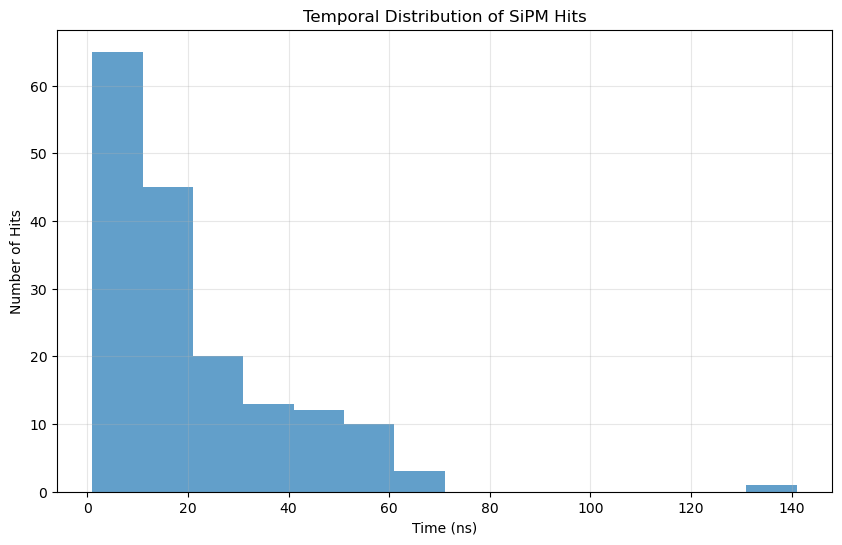

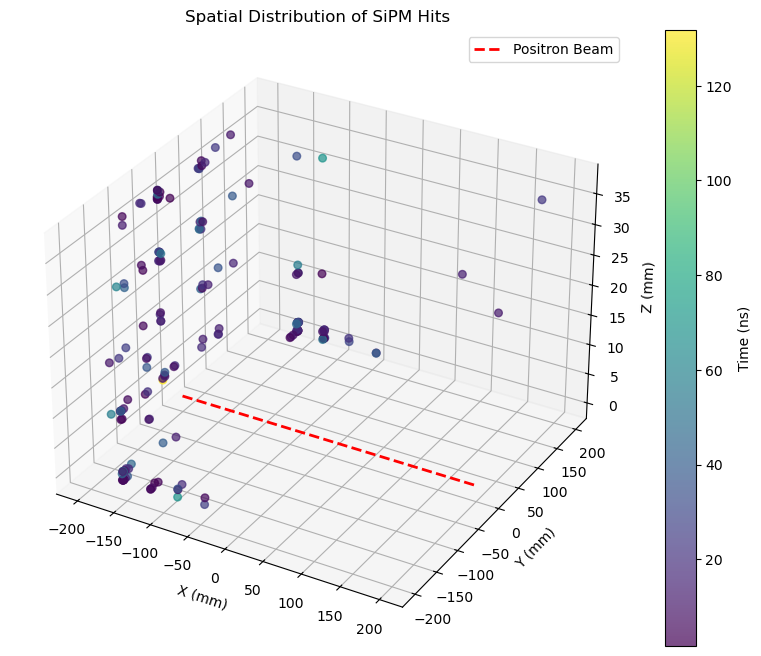

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def load_sipm_data(csv_file_path):
    
    sipm_df = pd.read_csv(csv_file_path)
    print(f"Loaded {len(sipm_df)} SiPM hits")
    print(f"Time range: {sipm_df['Time(ns)'].min():.2f} to {sipm_df['Time(ns)'].max():.2f} ns")
    print(f" X: {sipm_df['X(mm)'].min():.2f} to {sipm_df['X(mm)'].max():.2f} mm")
    print(f" Y: {sipm_df['Y(mm)'].min():.2f} to {sipm_df['Y(mm)'].max():.2f} mm")
    print(f" Z: {sipm_df['Z(mm)'].min():.2f} to {sipm_df['Z(mm)'].max():.2f} mm")
    df1 = sipm_df[sipm_df['Time(ns)'] <= 21]
    print(df1)
    return sipm_df

def preprocess_sipm_data(sipm_df):
    
    sipm_df = sipm_df.sort_values(by='Time(ns)')
    
    processed_df = sipm_df.copy()
    processed_df = processed_df.rename(columns={
        'Time(ns)': 'time',
        'X(mm)': 'x',
        'Y(mm)': 'y', 
        'Z(mm)': 'z',
        'Energy(eV)': 'energy',
        'Wavelength(nm)': 'wavelength'
    })
    
    processed_df['hit_id'] = np.arange(len(processed_df))
    
    return processed_df

def analyze_sipm_distribution(sipm_df):
    
    sipm_counts = sipm_df['SipmName'].value_counts()
    print("\nTop 10 SiPMs by hit count:")
    print(sipm_counts.head(10))
    print(sipm_counts)
    return sipm_counts

def analyze_time_distribution(sipm_df, bin_width=10):
    
    time_min = sipm_df['Time(ns)'].min()
    time_max = sipm_df['Time(ns)'].max()
    bins = np.arange(np.floor(time_min), np.ceil(time_max) + bin_width, bin_width)
    print("bins:", bins)
    plt.figure(figsize=(10, 6))
    plt.hist(sipm_df['Time(ns)'], bins=bins, alpha=0.7)
    plt.xlabel('Time (ns)')
    plt.ylabel('Number of Hits')
    plt.title('Temporal Distribution of SiPM Hits')
    plt.grid(alpha=0.3)
    plt.savefig('time_distribution.png')
    
    time_windows = pd.cut(sipm_df['Time(ns)'], bins)
    print("time_windows:", time_windows)
    window_counts = time_windows.value_counts().sort_index()
    print("window_counts", window_counts)
    print("\nHits per time window:")
    for window, count in window_counts.items():
        if count > 0:
            print(f"  {window}: {count} hits")
    
    return window_counts

def visualize_spatial_distribution(sipm_df):
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        sipm_df['X(mm)'], 
        sipm_df['Y(mm)'], 
        sipm_df['Z(mm)'],
        c=sipm_df['Time(ns)'], 
        cmap='viridis',
        alpha=0.7,
        s=30
    )
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('Time (ns)')
    
    beam_start = [-200, 0, 0]
    beam_end = [200, 0, 0]
    ax.plot([beam_start[0], beam_end[0]], 
            [beam_start[1], beam_end[1]], 
            [beam_start[2], beam_end[2]], 
            'r--', linewidth=2, label='Positron Beam')
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Spatial Distribution of SiPM Hits')
    ax.legend()
    
    plt.savefig('spatial_distribution.png')
    
def identify_potential_outliers(sipm_df):
    
    time_mean = sipm_df['Time(ns)'].mean()
    time_std = sipm_df['Time(ns)'].std()
    time_threshold = time_mean + 3 * time_std
    
    time_outliers = sipm_df[sipm_df['Time(ns)'] > time_threshold]
    
    print(f"\nIdentified {len(time_outliers)} potential time outliers:")
    if len(time_outliers) > 0:
        print(time_outliers)
    
    return time_outliers

def time_based_clustering(processed_df, max_time_gap=5):
    """
    Group SiPM hits into clusters based on time proximity
    
    Parameters:
    -----------
    processed_df : pandas DataFrame
        Preprocessed SiPM hit data
    max_time_gap : float
        Maximum time difference (in ns) between consecutive hits to be considered in the same cluster
        
    Returns:
    --------
    list of DataFrames, each containing hits from one time cluster
    """
    # Ensure data is sorted by time
    processed_df = processed_df.sort_values(by='time')
    
    # Initialize clusters
    time_clusters = []
    current_cluster = [processed_df.iloc[0]]  # Start with the first hit
    last_time = processed_df.iloc[0]['time']
    
    # Group hits into time clusters
    for i in range(1, len(processed_df)):
        current_hit = processed_df.iloc[i]
        current_time = current_hit['time']
        time_gap = current_time - last_time
        
        if time_gap <= max_time_gap:
            # Add to current cluster
            current_cluster.append(current_hit)
        else:
            # Start a new cluster
            time_clusters.append(pd.DataFrame(current_cluster))
            current_cluster = [current_hit]
        
        last_time = current_time
    
    # Add the last cluster if not empty
    if current_cluster:
        time_clusters.append(pd.DataFrame(current_cluster))
    
    # Print summary
    print(f"\nTime-based clustering complete:")
    print(f"Found {len(time_clusters)} time clusters with max gap = {max_time_gap} ns")
    for i, cluster in enumerate(time_clusters):
        print(f"Cluster {i+1}: {len(cluster)} hits, time range: {cluster['time'].min():.2f} - {cluster['time'].max():.2f} ns")
    
    return time_clusters

def visualize_time_clusters(time_clusters):
    """
    Visualize the time clusters in 3D space
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for different clusters
    colors = plt.cm.tab10(np.linspace(0, 1, len(time_clusters)))
    
    # Plot each cluster with a different color
    for i, cluster in enumerate(time_clusters):
        ax.scatter(
            cluster['x'], 
            cluster['y'], 
            cluster['z'],
            c=[colors[i]],  # Same color for all points in cluster
            label=f'Cluster {i+1} ({len(cluster)} hits)',
            alpha=0.7,
            s=30
        )
    
    # Draw the positron beam direction
    beam_start = [-200, 0, 0]
    beam_end = [200, 0, 0]
    ax.plot([beam_start[0], beam_end[0]], 
            [beam_start[1], beam_end[1]], 
            [beam_start[2], beam_end[2]], 
            'r--', linewidth=2, label='Positron Beam')
    
    # Set labels and title
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Time-based Clusters of SiPM Hits')
    
    # Add legend but keep it small and off to the side
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.savefig('time_clusters_3d.png')
    
    # Also create a time vs position plot
    plt.figure(figsize=(12, 6))
    
    for i, cluster in enumerate(time_clusters):
        plt.scatter(
            cluster['time'],
            cluster['x'],  # Using x-position
            c=[colors[i]],
            label=f'Cluster {i+1}',
            alpha=0.7,
            s=30
        )
    
    plt.xlabel('Time (ns)')
    plt.ylabel('X Position (mm)')
    plt.title('Time Clusters vs X Position')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig('time_clusters_vs_position.png')

def main_preprocessing(csv_file_path):
    
    sipm_df = load_sipm_data(csv_file_path)
    
    sipm_counts = analyze_sipm_distribution(sipm_df)
    time_windows = analyze_time_distribution(sipm_df)
    visualize_spatial_distribution(sipm_df)
    outliers = identify_potential_outliers(sipm_df)
    processed_df = preprocess_sipm_data(sipm_df)
              = time_based_clustering(sipm_df)
    return processed_df

if __name__ == "__main__":
    csv_file_path = "sipm_hits_run0.csv"
    processed_data = main_preprocessing(csv_file_path)
    
    print("\nPreprocessed data is ready for clustering and reconstruction")
    print(processed_data.head())
    
    processed_data.to_csv("preprocessed_sipm_hits.csv", index=False)